In [1]:
import os
from pathlib import Path

import cv2
import numpy as np
import tlc
import torch
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

from tlc_tools.common import infer_torch_device


In [2]:
# Project and model configuration
PROJECT_NAME = "3LC Tutorials"
DATASET_NAME = "AutoSegmented Images"
MODEL_TYPE = "vit_b"
CHECKPOINT = "../../transient_data/sam_vit_b_01ec64.pth"

# Image dataset configuration
IMAGE_DIR = "../../data/coco128/images"
MAX_IMAGES = 20  # Limit for initial testing - set to None for all images

# Segmentation filtering parameters
MIN_AREA_THRESHOLD = 1000  # Minimum area in pixels to keep a segment
MIN_CONFIDENCE_THRESHOLD = 0.7  # Minimum confidence score to keep a segment


In [3]:
# Get list of image files
image_dir = Path(IMAGE_DIR)
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
image_files = [f for f in image_dir.glob('*') if f.suffix.lower() in image_extensions]

if MAX_IMAGES is not None:
    image_files = image_files[:MAX_IMAGES]

print(f"Found {len(image_files)} images to process")
print(f"Sample images: {[f.name for f in image_files[:5]]}")


Found 20 images to process
Sample images: ['000000000009.jpg', '000000000025.jpg', '000000000030.jpg', '000000000034.jpg', '000000000036.jpg']


In [4]:
# Load SAM model
device = infer_torch_device()
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT)
sam.to(device=device)

# Initialize the automatic mask generator
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,  # Grid size for point prompts
    pred_iou_thresh=0.86,  # IoU threshold for mask quality filtering
    stability_score_thresh=0.92,  # Stability score threshold
    crop_n_layers=1,  # Number of crop layers
    crop_n_points_downscale_factor=2,  # Downscale factor for crop points
    min_mask_region_area=MIN_AREA_THRESHOLD,  # Minimum area in pixels
)

print(f"Initialized SAM Automatic Mask Generator on device: {device}")
print(f"Using model type: {MODEL_TYPE}")
print(f"Checkpoint: {CHECKPOINT}")


Initialized SAM Automatic Mask Generator on device: cuda
Using model type: vit_b
Checkpoint: ../../transient_data/sam_vit_b_01ec64.pth


In [5]:
from tqdm import tqdm

# Process each image and collect segmentations
segmentations_data = []

for image_path in tqdm(image_files, desc="Processing images"):
    # Load image
    image = cv2.imread(str(image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Generate masks for this image
    masks = mask_generator.generate(image_rgb)
    
    # Filter masks by confidence/stability score if desired
    filtered_masks = [
        mask for mask in masks 
        if mask.get('stability_score', 0) >= MIN_CONFIDENCE_THRESHOLD
    ]
    
    print(f"{image_path.name}: Generated {len(masks)} masks, kept {len(filtered_masks)} after filtering")
    
    if filtered_masks:
        # Convert masks to the format expected by 3LC
        h, w = image_rgb.shape[:2]
        
        # Stack all masks for this image into a single array
        mask_array = np.stack([mask['segmentation'] for mask in filtered_masks], axis=2).astype(np.uint8)
        
        # Create instance properties (scores, areas, etc.)
        instance_properties = {
            'score': [mask['stability_score'] for mask in filtered_masks],
            'area': [mask['area'] for mask in filtered_masks],
            'predicted_iou': [mask['predicted_iou'] for mask in filtered_masks],
        }
        
        segmentation_data = {
            'image_height': h,
            'image_width': w,
            'masks': mask_array,
            'instance_properties': instance_properties,
        }
        
        row_data = {
            'image': str(image_path),
            'segments': segmentation_data,
        }
        
        segmentations_data.append(row_data)

print(f"\\nProcessed {len(segmentations_data)} images with valid segmentations")


Processing images:   5%|▌         | 1/20 [00:11<03:45, 11.87s/it]

000000000009.jpg: Generated 64 masks, kept 64 after filtering


Processing images:  10%|█         | 2/20 [00:20<03:04, 10.24s/it]

000000000025.jpg: Generated 88 masks, kept 88 after filtering


Processing images:  15%|█▌        | 3/20 [00:30<02:50, 10.02s/it]

000000000030.jpg: Generated 76 masks, kept 76 after filtering


Processing images:  20%|██        | 4/20 [00:40<02:41, 10.12s/it]

000000000034.jpg: Generated 50 masks, kept 50 after filtering


Processing images:  25%|██▌       | 5/20 [00:51<02:33, 10.20s/it]

000000000036.jpg: Generated 66 masks, kept 66 after filtering
000000000042.jpg: Generated 90 masks, kept 90 after filtering


Processing images:  35%|███▌      | 7/20 [01:12<02:15, 10.43s/it]

000000000049.jpg: Generated 73 masks, kept 73 after filtering
000000000061.jpg: Generated 154 masks, kept 154 after filtering


Processing images:  40%|████      | 8/20 [01:22<02:04, 10.36s/it]

000000000064.jpg: Generated 90 masks, kept 90 after filtering


Processing images:  45%|████▌     | 9/20 [01:34<01:58, 10.73s/it]

000000000071.jpg: Generated 135 masks, kept 135 after filtering


Processing images:  55%|█████▌    | 11/20 [01:53<01:30, 10.08s/it]

000000000072.jpg: Generated 54 masks, kept 54 after filtering
000000000073.jpg: Generated 109 masks, kept 109 after filtering


Processing images:  60%|██████    | 12/20 [02:04<01:22, 10.32s/it]

000000000074.jpg: Generated 126 masks, kept 126 after filtering


Processing images:  65%|██████▌   | 13/20 [02:12<01:06,  9.50s/it]

000000000077.jpg: Generated 104 masks, kept 104 after filtering


Processing images:  75%|███████▌  | 15/20 [02:25<00:40,  8.12s/it]

000000000078.jpg: Generated 36 masks, kept 36 after filtering


Processing images:  80%|████████  | 16/20 [02:33<00:32,  8.07s/it]

000000000081.jpg: Generated 43 masks, kept 43 after filtering
000000000086.jpg: Generated 82 masks, kept 82 after filtering


Processing images:  85%|████████▌ | 17/20 [02:41<00:23,  7.79s/it]

000000000089.jpg: Generated 152 masks, kept 152 after filtering


Processing images:  95%|█████████▌| 19/20 [02:56<00:07,  7.74s/it]

000000000092.jpg: Generated 44 masks, kept 44 after filtering
000000000094.jpg: Generated 199 masks, kept 199 after filtering


Processing images: 100%|██████████| 20/20 [03:05<00:00,  9.29s/it]

\nProcessed 20 images with valid segmentations


In [19]:
for row in segmentations_data:
    row["image"] = Path(row["image"]).resolve().as_posix()

In [20]:
# Create the 3LC table with auto-generated segmentations
table_writer = tlc.TableWriter(
    project_name=PROJECT_NAME,
    dataset_name=DATASET_NAME,
    column_schemas={
        'image': tlc.Schema(value=tlc.ImageUrlStringValue()),
        'segments': tlc.InstanceSegmentationMasks(
            'auto-generated segments',
            instance_properties_structure={
                'score': tlc.Schema(value=tlc.Float32Value(0, 1), writable=False),
                'area': tlc.Schema(value=tlc.Int32Value(), writable=False),
                'predicted_iou': tlc.Schema(value=tlc.Float32Value(0, 1), writable=False),
            },
        ),
    }
)

# Add all the segmentation data to the table
for row_data in segmentations_data:
    table_writer.add_row(row_data)

# Finalize the table
table = table_writer.finalize()

print(f"\\nCreated 3LC table: {table.name}")
print(f"Table URL: {table.url}")
print(f"Total rows: {len(table)}")

# Display some statistics
total_segments = sum(len(row['segments']['instance_properties']['score']) for row in segmentations_data)
avg_segments_per_image = total_segments / len(segmentations_data) if segmentations_data else 0

print(f"\\nSegmentation Statistics:")
print(f"Total segments collected: {total_segments}")
print(f"Average segments per image: {avg_segments_per_image:.1f}")


\nCreated 3LC table: table_0001
Table URL: C:/Users/gudbrand/AppData/Local/3LC/3LC/projects/3LC Tutorials/datasets/AutoSegmented Images/tables/table_0001
Total rows: 20
\nSegmentation Statistics:
Total segments collected: 1835
Average segments per image: 91.8


In [22]:
table_writer.url

Url('C:/Users/gudbrand/AppData/Local/3LC/3LC/projects/3LC Tutorials/datasets/AutoSegmented Images/tables/table')

Sample image: 000000000009.jpg
Number of segments: 64
Score range: 0.921 - 0.984
Area range: 60 - 75836 pixels


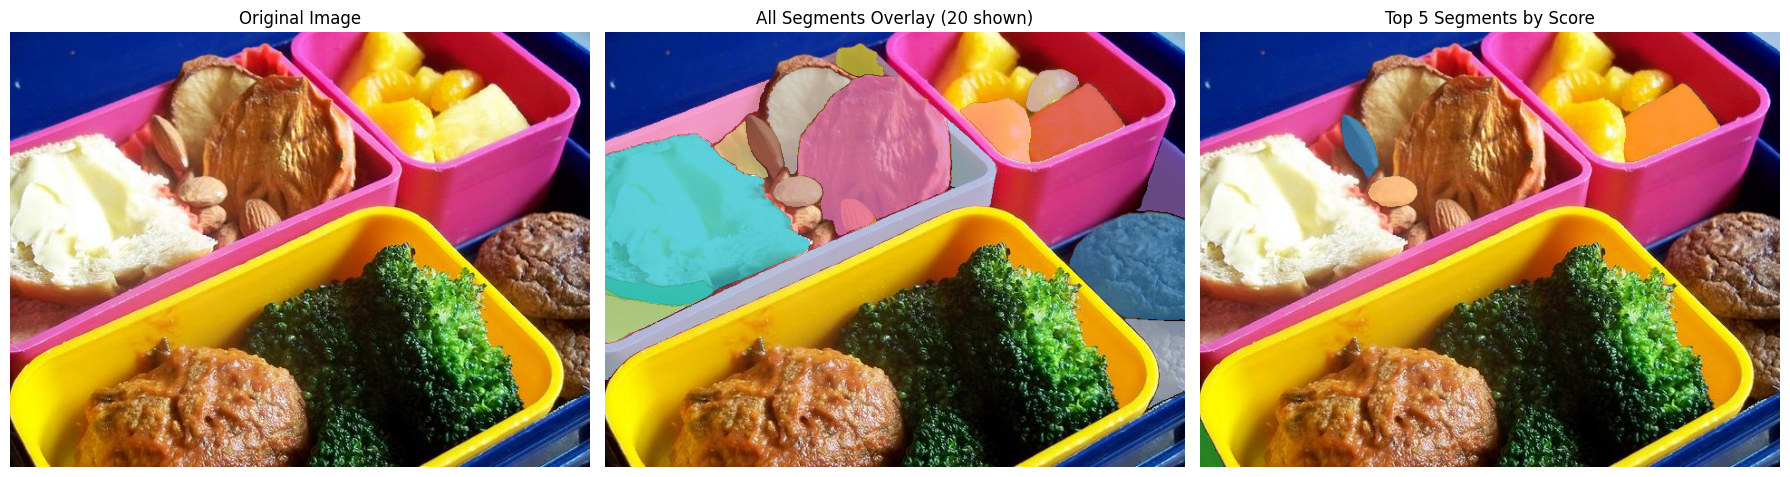

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import random

if len(table) > 0:
    # Get a sample from the table
    sample_idx = 0
    sample = table[sample_idx]
    
    # Load the original image
    image_path = sample['image']
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get the segmentation masks
    masks = sample['segments']['masks']
    scores = sample['segments']['instance_properties']['score']
    areas = sample['segments']['instance_properties']['area']
    
    print(f"Sample image: {Path(image_path).name}")
    print(f"Number of segments: {masks.shape[2]}")
    print(f"Score range: {min(scores):.3f} - {max(scores):.3f}")
    print(f"Area range: {min(areas)} - {max(areas)} pixels")
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # All masks overlay
    axes[1].imshow(image_rgb)
    combined_mask = np.zeros((masks.shape[0], masks.shape[1]))
    colors = plt.cm.tab20(np.linspace(0, 1, min(20, masks.shape[2])))
    
    for i in range(min(masks.shape[2], 20)):  # Show up to 20 masks
        mask = masks[:, :, i]
        if mask.sum() > 0:
            # Create colored overlay
            colored_mask = np.zeros((*mask.shape, 4))
            colored_mask[mask == 1] = colors[i % len(colors)]
            axes[1].imshow(colored_mask, alpha=0.7)
    
    axes[1].set_title(f"All Segments Overlay ({min(masks.shape[2], 20)} shown)")
    axes[1].axis('off')
    
    # Individual high-quality masks
    axes[2].imshow(image_rgb)
    # Show only the top 5 masks by score
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]
    
    for i, mask_idx in enumerate(top_indices):
        mask = masks[:, :, mask_idx]
        if mask.sum() > 0:
            colored_mask = np.zeros((*mask.shape, 4))
            colored_mask[mask == 1] = colors[i % len(colors)]
            axes[2].imshow(colored_mask, alpha=0.8)
    
    axes[2].set_title("Top 5 Segments by Score")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No images processed successfully")


In [10]:
table

TableFromParquet(project_name="3LC Tutorials", dataset_name="AutoSegmented Images", name="table_0000", row_count=20)